In [3]:
# note: to compare to RIce & Brewer 2020, I need the 
# SPOCS sample and parameters from Figure 7. I'm not sure where to get these.
# for now I'm going to try to compare to the SpeecMatch library
# which is used to validate specmatch

# I need table A1
# I don't see it on CDS, what about from the specmatch package?

In [4]:
from astropy.io import fits
from astropy.table import Table
import thecannon as tc
import specmatchemp.library
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import gaia

# load 403 stars + parameters from the specmatch-emp library
smemp_stars = specmatchemp.library.read_hdf(wavlim=[5140,5200]).library_params
print(len(smemp_stars), ' smemp stars in library')

# remove non-main sequence stars that the Cannon shouldn't fit
smemp_stars = smemp_stars.query('logg > 4')
print(len(smemp_stars), ' with logg > 4')

# Gaia crossmatch
# 4 targets gave errors in Gaia query (GJ15, GJ105, GJ166, and GJ412)
# and two were not in query results (HD 124257 A, HD39587)
# found by querying ./data/smemp_library_star_names.txt on gaia
gaia_smemp_xmatch = pd.read_csv('./data/gaia_smemp_xmatch.csv')
smemp_stars_gaia = pd.merge(
    smemp_stars, 
    gaia_smemp_xmatch[['target_id', 'source_id']], 
    left_on='source_name', 
    right_on='target_id')
print(len(smemp_stars_gaia), ' found in Gaia-smemp crossmatch')

# crossmatch is missing 6 targets
# adding 2 that I found manually on the Gaia archive 
# the others gave an error when I queried them individually
missing_target_ids = {
    'HD 124257 A' : 1511593059561180032,
    'HD39587' : 3399063235755057792}
for target_id in missing_target_ids.keys():
    row = smemp_stars[smemp_stars.source_name==target_id].iloc[0]
    row['target_id'] = target_id
    row['source_id'] = missing_target_ids[target_id]
    smemp_stars_gaia = smemp_stars_gaia.append(row)
print(len(smemp_stars_gaia), 'with Gaia DR3 IDs after adding manually-identified KIC IDs')

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Reading library from /Users/isabelangelo/.specmatchemp/library.h5
403  smemp stars in library
296  with logg > 4
290  found in Gaia-smemp crossmatch
292 with Gaia DR3 IDs after adding manually-identified KIC IDs


/var/folders/pk/t44zjr6913b62d97t1gt20680000gn/T/ipykernel_1446/2147852318.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  smemp_stars_gaia = smemp_stars_gaia.append(row)
/var/folders/pk/t44zjr6913b62d97t1gt20680000gn/T/ipykernel_1446/2147852318.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  smemp_stars_gaia = smemp_stars_gaia.append(row)


In [5]:
# query to run in Gaia
query = f"SELECT smemp.source_id, smemp.target_id, \
smemp.Teff, smemp.u_Teff, \
smemp.logg, smemp.u_logg, \
smemp.feh, smemp.u_feh, \
smemp.vsini, \
dr3.rvs_spec_sig_to_noise, dr3.ra, dr3.dec \
FROM user_iangelo.smemp_stars_gaia as smemp \
JOIN gaiadr3.gaia_source as dr3 \
  ON dr3.source_id = smemp.source_id \
WHERE dr3.has_rvs = 'True'"

# upload smemp star IDs to Gaia
# gaia.upload_table(smemp_stars_gaia, 'smemp_stars_gaia')

# download data
smemp_stars_gaia_results, smemp_flux_df, smemp_sigma_df = gaia.retrieve_data_and_labels(query)
print(len(smemp_stars_gaia_results), 'stars with RVS spectra in DR3')

# save data to .csv files
gaia.write_labels_to_file(smemp_stars_gaia_results, 'smemp')
gaia.write_flux_data_to_csv(smemp_flux_df, smemp_sigma_df, 'smemp')

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 67 after filters based on Gaia DR3 labels
* Input list contains 67 source_IDs
* This list is split into 1 chunks of <= 5000 elements each
writing flux + flux errors to dataframes
67 stars with RVS spectra in DR3
smemp labels saved to ./data/smemp_labels.csv
smemp flux, sigma dataframe saved to:
./data/smemp_flux.csv
./data/smemp_sigma.csv


In [6]:
# maybe I need to rename some of these? but it shouldn't be too hard
# then I can take maybe like 10/15 minutes to think about making this into a function

# function to plot one-to-one plot for smemp
def plot_one_to_one(label_df, flux_df, sigma_df, model, 
    figure_path, path_to_save_labels=None):
    """
    Plot a one-to-one comparison of the training set labels from GALAH and the Cannon
    labels inferred from the training set spectra.

    Args:
        label_df (pd.Dataframe) : training labels of sample to plot (n_objects x n_labels)
        flux_df (pd.Dataframe) : flux of sample to plot (n_pixels x n_objects)
        sigma_df (pd.Dataframe) : sigma of sample to plot (n_pixels x n_objects)
        model (tc.CannonModel) : cannon model object to test
        figure_path (str) : full path to save plot to 
        path_to_save_labels (str) : full path to save injected + recovered labels, if given
    """
    validation_str = 'smemp'
    pc = 'k';markersize=1;alpha_value=0.5
    full_labels = ['teff', 'logg','feh', 'alpha', 'vbroad']
    labels_to_plot = [i for i in full_labels if i!='alpha']
    validation_keys = [validation_str+'_'+ i for i in labels_to_plot] + ['rvs_spec_sig_to_noise']
    cannon_keys = ['cannon_'+ i for i in full_labels] + ['cannon_chi_sq']

    def compute_cannon_labels(label_df, flux_df, sigma_df):

        cannon_label_data = []
        # iterate over each object
        for source_id in label_df.source_id.to_numpy():
            # store galah labels
            row = label_df.loc[label_df.source_id==source_id]
            validation_labels = row[validation_keys].values.flatten().tolist()
            # retrieve data
            flux = flux_df[str(source_id)]
            sigma = sigma_df[str(source_id)]
            ivar = 1/sigma**2

            # fit cannon model with custom optimizer
            cannon_labels = model.test(flux, ivar)[0][0].tolist()

            # convert to dictionary
            keys = ['source_id'] + validation_keys + cannon_keys
            values = [source_id] + validation_labels + cannon_labels
            cannon_label_data.append(dict(zip(keys, values)))

        cannon_label_df = pd.DataFrame(cannon_label_data)
        return cannon_label_df

    def plot_label_one_to_one(label_df, label):
        x = label_df['{}_{}'.format(validation_str, label)]
        y = label_df['cannon_{}'.format(label)]
        z = label_df['rvs_spec_sig_to_noise']
        diff = y - x
        bias = np.round(np.mean(diff), 3)
        rms = np.round(np.sqrt(np.sum(diff**2)/len(diff)), 3)
        subplot_label = 'bias, rms = {}, {}'.format(bias, rms)
        plt.scatter(x, y, c=z, vmin=200,vmax=800, s=10, cmap='viridis_r')
        plt.plot([], [], '.', color='w', label=subplot_label)
        plt.xlabel('SpecMatch-Emp {}'.format(label));plt.ylabel('Cannon {}'.format(label))
        plt.plot([x.min(), x.max()], [x.min(), x.max()], lw=0.7, color='lightgrey')
        plt.legend(loc='upper left', frameon=False, labelcolor='tomato')
        plt.colorbar(label='RVS spectrum SNR')

    def plot_label_difference(label_df, label):
        x = label_df['{}_{}'.format(validation_str, label)]
        y = label_df['cannon_{}'.format(label)]
        diff = y - x
        plt.hist(diff, histtype='step', color=pc)
        plt.xlabel(r'$\Delta {}$'.format(label))

    cannon_label_df = compute_cannon_labels(
        label_df, 
        flux_df, 
        sigma_df)

    if path_to_save_labels is not None:
        cannon_label_filename = './data/'+path_to_save_labels+'.csv'
        cannon_label_df.to_csv(cannon_label_filename)
        print('cannon label dataframe saved to {}'.format(cannon_label_filename))
        
    # define axis limits
    axis_limit_values = [(4500,7000), (4.0,4.8), (-0.5,0.5), (0,15)]
    axis_limit_dict = dict(zip(labels_to_plot, axis_limit_values))

    gs = gridspec.GridSpec(5, 2, width_ratios=[1.2, 1])
    plt.figure(figsize=(10,17))
    for i in range(len(labels_to_plot)):
        plt.subplot(gs[2*i])
        label = labels_to_plot[i]
        axis_min, axis_max = axis_limit_dict[label]
#         plt.xlim(axis_min, axis_max)
#         plt.ylim(axis_min, axis_max)
        plot_label_one_to_one(cannon_label_df, label)
        plt.subplot(gs[2*i+1])
        plot_label_difference(cannon_label_df, label)
#     plt.savefig(figure_path, dpi=300, bbox_inches='tight')

In [7]:
# load data
smemp_label_df = pd.read_csv('./data/smemp_labels.csv')
smemp_flux_df = pd.read_csv('./data/smemp_flux.csv')
smemp_sigma_df = pd.read_csv('./data/smemp_sigma.csv')
model = tc.CannonModel.read('../gaia_binaries/data/cannon_models/gaia_rvs_model.model')

# rename columns to plotting code works
smemp_label_df = smemp_label_df.rename(
    columns={
    "teff": "smemp_teff", 
    "logg": "smemp_logg",
    "feh":"smemp_feh",
    "vsini":"smemp_vbroad",
    })

plot_one_to_one(
    smemp_label_df, 
    smemp_flux_df, 
    smemp_sigma_df, 
    model, 
    './smemp_one_to_one.png', path_to_save_labels='smemp_cannon_labels')

stty: stdin isn't a terminal
2023-07-27 11:57:02,287 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2023-07-27 11:57:02,289 [INFO] Running test step on 1 spectra


[=                                                                                                   ] 100% (1s)                         
> /var/folders/pk/t44zjr6913b62d97t1gt20680000gn/T/ipykernel_1446/356098317.py(30)compute_cannon_labels()
     28         cannon_label_data = []
     29         # iterate over each object
---> 30         for source_id in label_df.source_id.to_numpy():
     31             # store galah labels
     32             row = label_df.loc[label_df.source_id==source_id]

ipdb> exit()


In [ ]:
# as we can see when we remove the axis limits, this model doesn't perform well
# mostly for the low SNR targets.

# could it be because the true parameters are outside a viable range?
# and the model shouldn't perform well?

# otherwise I should look at some individual systems.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(array([  4.,  15.,  37.,  71., 179., 132.,  51.,   8.,   3.,   5.]),
 array([4138.2544 , 4522.74206, 4907.22972, 5291.71738, 5676.20504,
        6060.6927 , 6445.18036, 6829.66802, 7214.15568, 7598.64334,
        7983.131  ]),
 <BarContainer object of 10 artists>)

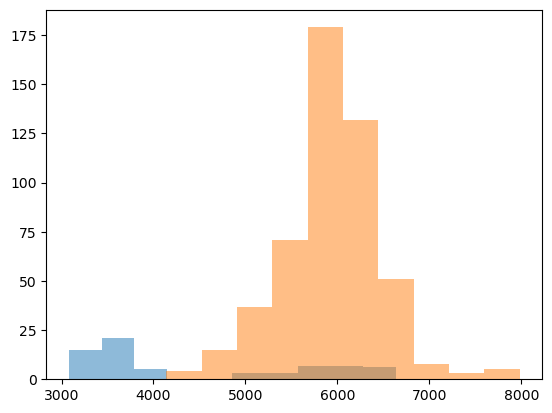

In [48]:
# already it looks like these are not right...
# let me look at the training set histogram
# okay...the smemp library is way off from the RVS training set,
# I don't think it's very relevant...it's mostly cool stars?
# this doesn't seem right though and I should double check.

# also...is the CKS sample in the right range?
# I need to overplot the training set histogram
# and the validation sample histogram.

training_label_df = pd.read_csv('../gaia_binaries/data/galah_label_dataframes/training_labels.csv')

%pylab inline
hist(smemp_label_df.smemp_teff, alpha=0.5) 
hist(training_label_df.galah_teff, alpha=0.5)

Reading library from /Users/isabelangelo/.specmatchemp/library.h5


(array([  4.,  15.,  37.,  71., 179., 132.,  51.,   8.,   3.,   5.]),
 array([4138.2544 , 4522.74206, 4907.22972, 5291.71738, 5676.20504,
        6060.6927 , 6445.18036, 6829.66802, 7214.15568, 7598.64334,
        7983.131  ]),
 <BarContainer object of 10 artists>)

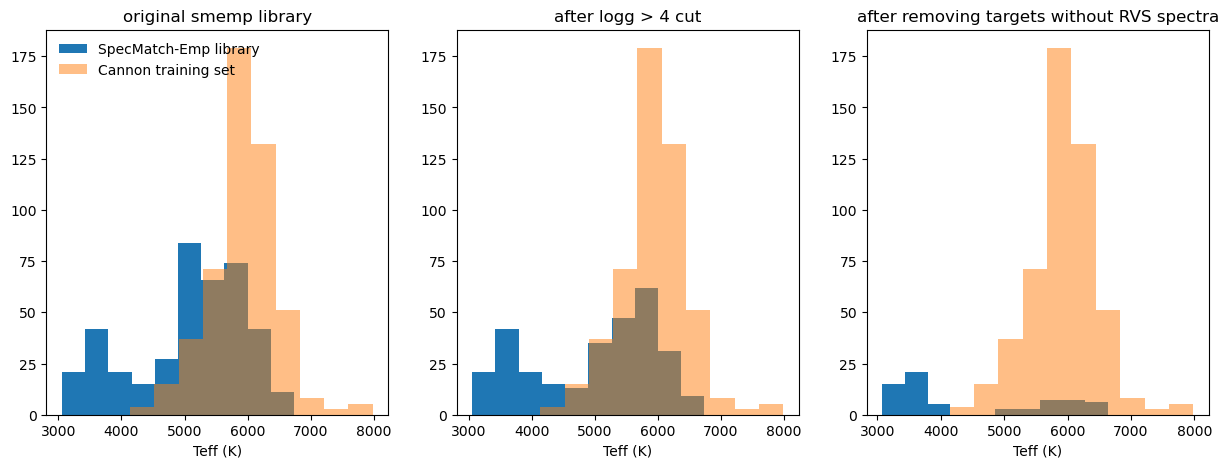

In [57]:
# okay, this looks more right...
# what step changes this? is it the has_rvs?
figure(figsize=(15,5))
subplot(131);title('original smemp library')
test_df = specmatchemp.library.read_hdf(wavlim=[5140,5200]).library_params
hist(test_df.Teff, label='SpecMatch-Emp library');xlabel('Teff (K)')
hist(training_label_df.galah_teff, label='Cannon training set', alpha=0.5)
legend(loc='upper left', frameon=False)

subplot(132);title('after logg > 4 cut')
test_df2 = test_df.query('logg > 4')
hist(test_df2.Teff);xlabel('Teff (K)')
hist(training_label_df.galah_teff, alpha=0.5)

subplot(133);title('after removing targets without RVS spectra')
test_df3 = smemp_stars_gaia_results
hist(test_df3.teff);xlabel('Teff (K)')
hist(training_label_df.galah_teff, alpha=0.5)